# Project 2: Traffic Sign Classifier Solution : LeNet architecture as base
![LeNet Architecture](lenet.png)
Source: Yan LeCun

### The goals / steps of this project are the following:
Load the data set

Explore, summarize and visualize the data set.

Design, train and test a model architecture.

Use the model to make predictions on new images.

Analyze the softmax probabilities of the new images.

Summarize the results with a written report.


## Load Data

In [13]:
##### Data Set Summary & Exploration
# Load pickled data
import pickle
import cv2
from numpy import newaxis
from skimage import exposure
import random
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

## Summarize Data

In [14]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

X_web = []
for i in range (1,6):
    img = mpimg.imread('web'+str(i)+'.jpg')    
    X_web = X_web + [img]

Y_web = [38,28,27,22,14]

# Finding out how many unique classes/labels there are in the dataset
unique, counts = np.unique(y_train, return_counts=True)

print("Original Image Shape:  ",X_train[0].shape)
print("Training Set size:     ",len(X_train))
print("Validation Set size:   ",len(X_valid))
print("Test Set size:         ",len(X_test))
print("Number of classes:     ", len(unique))

Original Image Shape:   (32, 32, 3)
Training Set size:      34799
Validation Set size:    4410
Test Set size:          12630
Number of classes:      43


## Explore Data

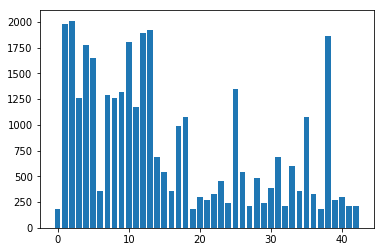

In [15]:
###### Exploratory visualization of the dataset
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.show()

## Visualize Data

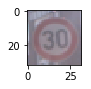

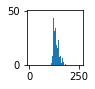

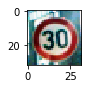

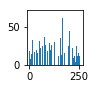

In [16]:
##### Visualize and verify hist equalization
# Pick one of the images
test = X_train[2567].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(test)

# Orig image histogram
testgray = cv2.cvtColor(test, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(1,1))
plt.hist(testgray.ravel(),256,[0,256])
plt.show()

# Equalizer
b,g,r = cv2.split(test)
b = exposure.equalize_hist(b)
g = exposure.equalize_hist(g)
r = exposure.equalize_hist(r)
equalized = cv2.merge((b,g,r))
plt.figure(figsize=(1,1))
plt.imshow(equalized)

# Equalized image histogram
equalized_rescaled = exposure.rescale_intensity(equalized, out_range=(0, 255))
plt.figure(figsize=(1,1))
plt.hist(equalized_rescaled.ravel(),256,[0,256])
plt.show()

## Preprocess Data

In [17]:
##### Preprocessing functions 

def normalize(images):
    a = []
    for image in images:
        a.append((image-128)/255)
    return a

def shapeadjust(images):    
    a = []
    for x in images:
        a.append(x[...,newaxis])    
    return a

# hist_equalizer function works better on single channel images hence split and merge
def hist_equalizer(images): 
    eq = []
    for image in images:
        b,g,r = cv2.split(image)
        b = exposure.equalize_hist(b)
        g = exposure.equalize_hist(g)
        r = exposure.equalize_hist(r)
        img = cv2.merge((b,g,r))
        img = exposure.rescale_intensity(img, out_range=(0, 255))
        eq.append(img)
    return eq

# Equalize data
X_train = hist_equalizer(X_train)
X_valid = hist_equalizer(X_valid)
X_test = hist_equalizer(X_test)
X_web = hist_equalizer(X_web)

# Normalization of data
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)
X_web = normalize(X_web)

In [18]:
# Shuffle the training data.
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

In [19]:
import tensorflow as tf

EPOCHS = 90
BATCH_SIZE = 64

## SOLUTION: Implement modified LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture as the base architecture and adjust/tweak as required for this application.

### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels.I have used color images hence C = 3

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** RELU as an activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** RELU as an activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, flatten into 400 outputs

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** RELU as an activation function.

**Dropout.** Dropout layer with keep_prob = 0.5 for training.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** RELU as an activation function.

**Dropout.** Dropout layer with keep_prob = 0.5 for training.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [20]:
from tensorflow.contrib.layers import flatten

def LeNet(x, dropout):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.05
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    F1_w = tf.Variable(tf.truncated_normal(shape = (5,5,3,6), mean = mu, stddev = sigma))
    F1_b = tf.Variable(tf.zeros(6))
    c1 = tf.nn.conv2d(x, F1_w, strides = [1,1,1,1], padding = 'VALID') + F1_b
   
    # Activation.
    c1 = tf.nn.relu(c1)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    p1 = tf.nn.max_pool(c1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    F2_w = tf.Variable(tf.truncated_normal(shape = (5,5,6,16), mean = mu, stddev = sigma))
    F2_b = tf.Variable(tf.zeros(16))   
    c2 = tf.nn.conv2d(p1, F2_w, strides = [1,1,1,1], padding = 'VALID') + F2_b
    
    # Activation.
    c2 = tf.nn.relu(c2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    p2 = tf.nn.max_pool(c2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    flat_input = flatten(p2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    l3_weights = tf.Variable(tf.truncated_normal(shape = (400,120), mean = mu, stddev = sigma))
    l3_bias = tf.Variable(tf.zeros(120))
    l3 = tf.matmul(flat_input,l3_weights) + l3_bias
        
    # Activation.
    l3 = tf.nn.relu(l3)
    
    # Dropout
    l3 = tf.nn.dropout(l3, dropout)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    l4_weights = tf.Variable(tf.truncated_normal(shape = (120,84), mean = mu, stddev = sigma))
    l4_bias = tf.Variable(tf.zeros(84))
    l4 = tf.matmul(l3,l4_weights) + l4_bias
        
    # Activation.
    l4 = tf.nn.relu(l4)
    
    # Dropout
    l4 = tf.nn.dropout(l4, dropout)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    l5_weights = tf.Variable(tf.truncated_normal(shape = (84,43), mean = mu, stddev = sigma))
    l5_bias = tf.Variable(tf.zeros(43))
    logits = tf.matmul(l4,l5_weights) + l5_bias
        
    return logits

## Features and Labels
Train LeNet to classify the traffic sign data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.


In [21]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) #dropout - keep probability
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline
Create a training pipeline that uses the model to classify the traffic sign data.

In [22]:
rate = 0.0009
dropout = 0.50

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [23]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.})        
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

Training...

EPOCH 1 ...
Training Accuracy = 0.616
Validation Accuracy = 0.592

EPOCH 2 ...
Training Accuracy = 0.834
Validation Accuracy = 0.790

EPOCH 3 ...
Training Accuracy = 0.902
Validation Accuracy = 0.858

EPOCH 4 ...
Training Accuracy = 0.924
Validation Accuracy = 0.883

EPOCH 5 ...
Training Accuracy = 0.944
Validation Accuracy = 0.896

EPOCH 6 ...
Training Accuracy = 0.962
Validation Accuracy = 0.926

EPOCH 7 ...
Training Accuracy = 0.967
Validation Accuracy = 0.932

EPOCH 8 ...
Training Accuracy = 0.974
Validation Accuracy = 0.938

EPOCH 9 ...
Training Accuracy = 0.978
Validation Accuracy = 0.945

EPOCH 10 ...
Training Accuracy = 0.983
Validation Accuracy = 0.949

EPOCH 11 ...
Training Accuracy = 0.984
Validation Accuracy = 0.952

EPOCH 12 ...
Training Accuracy = 0.986
Validation Accuracy = 0.954

EPOCH 13 ...
Training Accuracy = 0.987
Validation Accuracy = 0.954

EPOCH 14 ...
Training Accuracy = 0.988
Validation Accuracy = 0.955

EPOCH 15 ...
Training Accuracy = 0.991
Valid

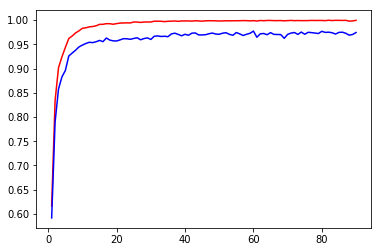

Model saved


In [24]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    trainacc = []
    validacc = []    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:dropout})
                    
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)        
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        validacc = validacc + [validation_accuracy]
        trainacc = trainacc + [training_accuracy]     
        
    x_axis = list(range(1,EPOCHS+1))
    plt.plot(x_axis, trainacc, 'r-', label = "train")
    plt.plot(x_axis, validacc, 'b-', label = "valid")    
    plt.show()
    saver.save(sess, './lenet')
    print("Model saved")

## Evaluate the Model
Once I was completely satisfied with the model, evaluate the performance of the model on the test set.

Be sure to only do this once! 

##### If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

## Softmax calculations

In [25]:
# Calculating softmax probabilities for web images
web_logits = tf.placeholder(tf.float32)
softmax = tf.nn.softmax(logits)

## Calculate test set and web image set accuracy

In [26]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    web_accuracy = evaluate(X_web, Y_web)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("Web Accuracy = {:.3f}".format(web_accuracy))
    
    softmax_web = sess.run(softmax, feed_dict = {x: X_web, keep_prob:1.0})
    top5 = sess.run(tf.nn.top_k(tf.constant(softmax_web), k=5))

print()
print(top5)

Test Accuracy = 0.952
Web Accuracy = 0.200

TopKV2(values=array([[  9.99993563e-01,   6.46626131e-06,   3.15594271e-08,
          7.41227923e-09,   4.73859529e-09],
       [  8.69080722e-01,   1.22919701e-01,   5.14015881e-03,
          1.70091947e-03,   1.11319788e-03],
       [  9.97026145e-01,   1.72651478e-03,   1.13352295e-03,
          4.94772466e-05,   3.14582030e-05],
       [  1.00000000e+00,   3.25773399e-08,   7.65973596e-09,
          1.79895698e-09,   5.67941083e-10],
       [  8.64816427e-01,   1.33846104e-01,   1.33743125e-03,
          1.90273095e-08,   3.41642076e-10]], dtype=float32), indices=array([[18, 26, 20, 40, 27],
       [39,  2, 15, 33,  4],
       [25, 29, 24,  5, 30],
       [22, 26, 20, 18, 25],
       [12, 17, 13, 26, 15]]))


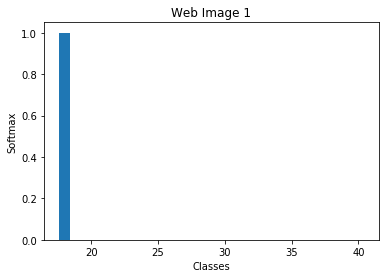

In [33]:
# Plot softmax
plt.bar([18, 26, 20, 40, 27],[9.99993563e-01,6.46626131e-06,3.15594271e-08,7.41227923e-09,4.73859529e-09])
plt.xlabel('Classes')
plt.ylabel('Softmax')
plt.title('Web Image 1')
plt.show()

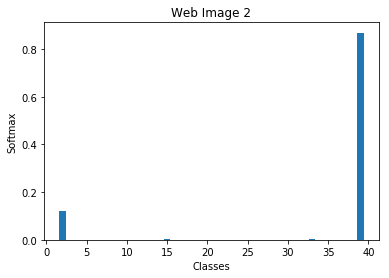

In [34]:
# Plot softmax
plt.bar([39,  2, 15, 33,4],[8.69080722e-01,1.22919701e-01,5.14015881e-03,1.70091947e-03,1.11319788e-03])
plt.xlabel('Classes')
plt.ylabel('Softmax')
plt.title('Web Image 2')
plt.show()

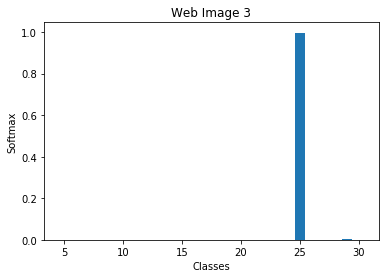

In [36]:
# Plot softmax
plt.bar([25, 29, 24,  5, 30],[9.97026145e-01,1.72651478e-03,1.13352295e-03,4.94772466e-05,3.14582030e-05])
plt.xlabel('Classes')
plt.ylabel('Softmax')
plt.title('Web Image 3')
plt.show()

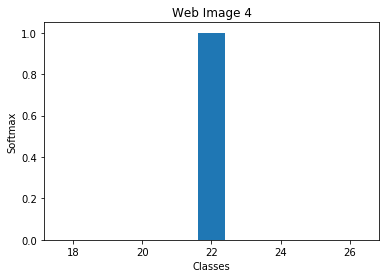

In [37]:
# Plot softmax
plt.bar([22, 26, 20, 18, 25],[1.00000000e+00,3.25773399e-08,7.65973596e-09,1.79895698e-09,5.67941083e-10])
plt.xlabel('Classes')
plt.ylabel('Softmax')
plt.title('Web Image 4')
plt.show()

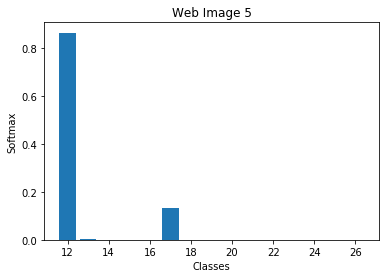

In [38]:
# Plot softmax
plt.bar([12, 17, 13, 26, 15],[8.64816427e-01,1.33846104e-01,1.33743125e-03,1.90273095e-08,3.41642076e-10])
plt.xlabel('Classes')
plt.ylabel('Softmax')
plt.title('Web Image 5')
plt.show()